# Image Recognation Project Dataset

<b>CIFAR-10</b> is by now a classical computer-vision dataset for object recognition case study. It is a subset of the 80 million tiny images dataset that was designed and created by the Canadian Institute for Advanced Research (CIFAR, pronounced "see far").
The CIFAR-10 dataset consists of 60000 <b>32x32x3</b> color images in 10 equal classes, (6000 images per class). Each class of images corresponds to a physical object (automobile, cat, dog, airplane, etc).
Dataset website: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

## Look at the current directory
%ls

gdrive/  sample_data/


In [3]:
## Change the current dire
#%cd 'gdrive/My Drive/CIFAR_Image_Recognition'
%cd 'gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition'

/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition


# Import Data and Packages

In [4]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.layers.noise import GaussianNoise
#from keras.layers.advanced_activations import SReLU
#from keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import numpy as np
import dlutils
import kerutils
from dlutils import *
from kerutils import *

The CIFAR-10 image classes are encoded as integers 0-9 by the following Python dictionary

In [5]:
nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

Loading Training and test data

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])  # somehow y_train comes as a 2D nx1 matrix
y_test = y_test.reshape(y_test.shape[0])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

170508288/170498071 [==============================] - 3s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


The original data of each image is a 32x32x3 matrix of integers from 0 to 255. We need to scale it down to floats in the unit interval

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>
3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]<br>
etc...

In [8]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Let's also write two small utilities for drawing samples of images, so we can inspect our results visually.

In [9]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Let's draw image 7 in X_train for example

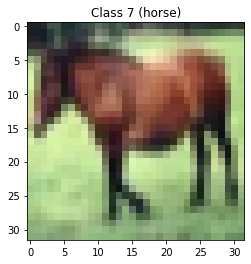

In [10]:
draw_img(7)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

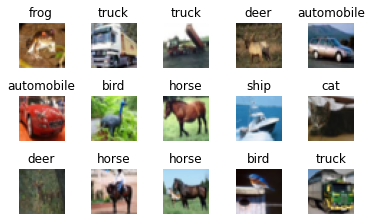

In [11]:
draw_sample(X_train, y_train, 0,3,5)

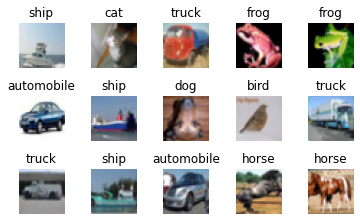

In [12]:
draw_sample(X_train, y_train, 100, 3, 5)

# Building Neural Network for the image set

The input layer would have to be of size 3072 (as every image is a 32x32x3 matrix). If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


We will use two types of training:<br>
<b>Standard training</b>: the usual Keras fit method<br>



# Let's Train Model 

In [13]:
nb_epoch = 10
batch_size = 32

model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), activation='relu')) # add parameters and activation function
model1.add(Dropout(0.2)) # add parameters 
model1.add(Convolution2D(32, 3, 3, activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters 
model1.add(Flatten())
model1.add(Dense(16, activation='relu')) # add parameters and activation function
model1.add(Dropout(0.5)) # add parameters 
model1.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
lrate = 0.01 # add learning rate parameters
decay = lrate/nb_epoch
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)

print('Saving model1 to the file "model_1.h5"')
model1.save("model_1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0

Try another architecture

In [14]:
nb_epoch = 10
batch_size = 32

model2 = Sequential()
model2.add(Convolution2D(4, 2, 2, input_shape=(32, 32, 3), activation='relu')) # add parameters and activation function
model2.add(MaxPooling2D(pool_size=(2, 2))) # add parameters 
model2.add(Convolution2D(8, 2, 2, activation='relu')) # add parameters and activation function
model2.add(MaxPooling2D(pool_size=(2, 2))) # add parameters 
model2.add(Flatten())
model2.add(Dense(32, activation='relu')) # add parameters and activation function
model2.add(Dense(nb_classes, activation='softmax')) # activation function
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

print('Standard Training.')

h = model2.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    shuffle=True
)

print('Saving model2 to the file "model_2.h5"')
model2.save("model_2.h5")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 4)         52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [15]:
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("nb_epoch =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()


In [16]:
def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)


Training: accuracy   = 0.283960 loss = 1.932501
Validation: accuracy = 0.282400 loss = 1.929252
Params count: 10842
stop epoch = 9
nb_epoch = 10


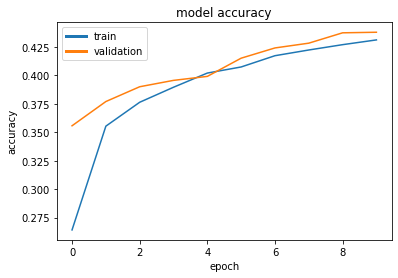

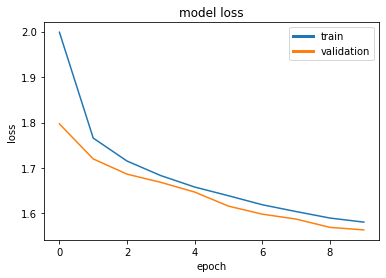

In [17]:
show_scores1(model1, h, X_train, Y_train, X_test, Y_test)

In [19]:
model1 = load_model("model_1.h5")

In [20]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Training: accuracy = 0.283960  ;  loss = 1.932501
Validation: accuracy1 = 0.282400  ;  loss1 = 1.929252


# Inspecting Output

Neverthelss, befor we search for a new model, let's take a quick look on some of the cases that our model1 missed. It may give us hints on the strengths an weaknesses of NN models, and what we can expect from these artificial models.<br>
The predict_classes method is helpful for getting a vector (y_pred) of the predicted classes of model1. We should compare y_pred to the expected true classes y_test in order to get the false cases:

In [21]:
y_pred = model1.predict_classes(X_test)
true_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Number of true predictions:  2824
Number of false predictions: 7176


Let's see images we can recognize

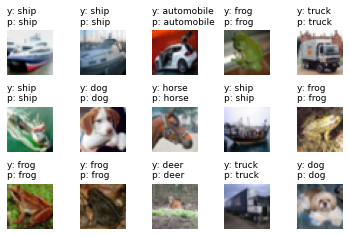

In [22]:
for i,(x,y,p) in enumerate(true_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

Let's see iamges we can not recognize.

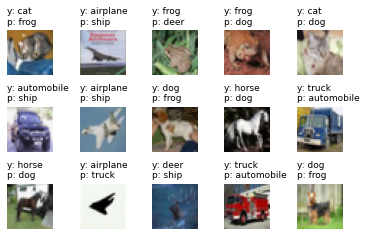

In [23]:
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)